In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/34 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N20.JPG
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N1.JPG
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/49 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N15.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/No18.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/31 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/no 6.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/3 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/no 5.jpeg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/no 1.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/26 no.jpg
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N26.JPG
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N5.jpg
/kaggle/input/brain-mri-images-for-b

***Import Library and Load Dataset***


In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader, Dataset
from torchvision import datasets, models, transforms
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

***Visualization***

In [3]:
dataset_path = "/kaggle/input/brain-mri-images-for-brain-tumor-detection"
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
class_names = dataset.classes
class_names = class_names[1:]

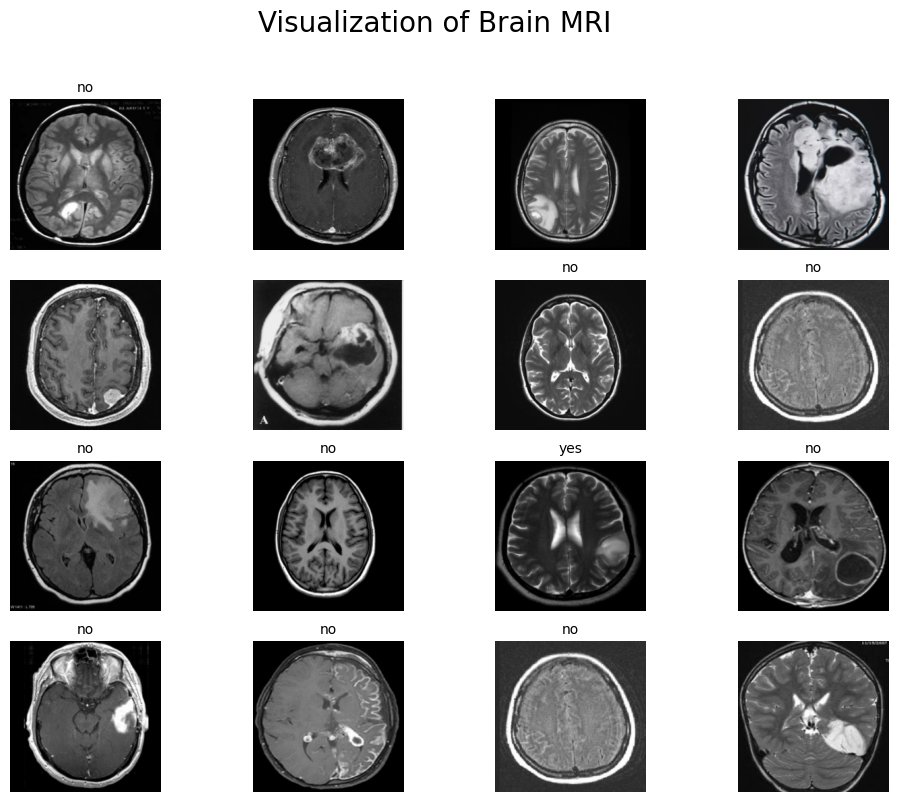

In [4]:
fig = plt.figure(figsize=(12, 9))
rows, cols = 4, 4

for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(dataset), size=[1]).item()
    img, label = dataset[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.permute(1, 2, 0))
    plt.suptitle("Visualization of Brain MRI", fontsize=20)
    if label < len(class_names):
        plt.title(class_names[label], fontsize=10)
    plt.axis(False);

***Data Preprocessing and Prepare***

In [5]:
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label
    
def load_dataset_from_directory(directory):
    image_paths = []
    labels = []

    class_names = ['no', 'yes']
    class_to_idx = {class_name: i for i, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            if img_path.endswith(('.png', '.jpg', 'JPG', '.jpeg')):  # Let's filter image file extensions
                image_paths.append(img_path)
                labels.append(class_to_idx[class_name])

    return image_paths, labels

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

image_paths, labels = load_dataset_from_directory(dataset_path)
dataset = CustomDataset(image_paths, labels, transform)

# Train-validation and dataset split
train_size = int(0.7 * len(dataset))  # %80 Train
val_test_size = len(dataset) - train_size  # %20 Validation-Test
train_dataset, val_test_dataset = random_split(dataset, [train_size, val_test_size])

val_size = int(0.6 * len(val_test_dataset)) # Val
test_size = len(val_test_dataset) - val_size # Test
val_dataset, test_dataset = random_split(val_test_dataset, [val_size, test_size])

# Load dataset with Dataloader with batch size
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

In [7]:
for i in torch.arange(253):
    print(image_paths[i], "\t", labels[i])

/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/34 no.jpg 	 0
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N20.JPG 	 0
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N1.JPG 	 0
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/49 no.jpg 	 0
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N15.jpg 	 0
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/No18.jpg 	 0
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/31 no.jpg 	 0
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/no 6.jpg 	 0
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/3 no.jpg 	 0
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/no 5.jpeg 	 0
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/no 1.jpg 	 0
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/26 no.jpg 	 0
/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/N26.JPG 	 0
/kaggle/input/brain-mri-images-for-brain-tumor-dete

In [8]:
# Check dataset dimensions
print(f"Total data: {len(dataset)}")
print(f"Train data dimension: {len(train_dataset)}")
print(f"Val data dimension: {len(val_dataset)}")
print(f"Test data dimension: {len(test_dataset)}")

Total data: 253
Train data dimension: 177
Val data dimension: 45
Test data dimension: 31


***Build the ResNet Model***

In [9]:
try:
    # If multiple GPUs are available, use them
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_gpus = torch.cuda.device_count()
    print(f"Using {num_gpus} GPUs for training." if num_gpus > 1 else f"Using {torch.cuda.get_device_name()} for training." if torch.cuda.is_available() else "Using CPU for training.")
except:
    print("No GPU found. Using CPU.")
    device = torch.device("cpu")

Using 2 GPUs for training.


*Using 2 GPUs for training.*

In [10]:
num_classes = len(class_names)
resnet152_model = models.resnet152(pretrained=True)
resnet152_model.fc = nn.Linear(resnet152_model.fc.in_features, num_classes).to(device)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 181MB/s]


In [11]:
resnet152_model


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
if num_gpus > 1:
    resnet152_model = nn.DataParallel(resnet152_model).to(device)

***Model Training***

In [13]:
# Training function
def train(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    for batch_inputs, batch_labels in train_loader:
        batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()
    average_loss = total_loss / len(train_loader)
    accuracy = correct / total * 100
    return average_loss, accuracy

# Validation function
def validate(model, val_loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_inputs, batch_labels in val_loader:
            batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)
            outputs = model(batch_inputs)
            loss = criterion(outputs, batch_labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()
    average_loss = total_loss / len(val_loader)
    accuracy = correct / total * 100
    return accuracy, average_loss

In [14]:
# Define criterion, optimizer and early_stopping
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet152_model.parameters(), lr=1e-4, weight_decay=1e-3)

# Training loop
num_epochs = 25
for epoch in range(num_epochs):
    train_loss, train_accuracy = train(resnet152_model, train_loader, criterion, optimizer)
    val_accuracy, val_loss = validate(resnet152_model, val_loader, criterion)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

print('Training was completed')

Epoch [1/25], Train Loss: 0.5442, Train Accuracy: 71.75%, Validation Loss: 0.5269, Validation Accuracy: 80.00%
Epoch [2/25], Train Loss: 0.1531, Train Accuracy: 98.87%, Validation Loss: 0.4260, Validation Accuracy: 86.67%
Epoch [3/25], Train Loss: 0.0397, Train Accuracy: 99.44%, Validation Loss: 0.4278, Validation Accuracy: 86.67%
Epoch [4/25], Train Loss: 0.0184, Train Accuracy: 100.00%, Validation Loss: 0.4972, Validation Accuracy: 88.89%
Epoch [5/25], Train Loss: 0.0063, Train Accuracy: 100.00%, Validation Loss: 0.5147, Validation Accuracy: 91.11%
Epoch [6/25], Train Loss: 0.0128, Train Accuracy: 99.44%, Validation Loss: 0.4631, Validation Accuracy: 93.33%
Epoch [7/25], Train Loss: 0.0314, Train Accuracy: 98.87%, Validation Loss: 0.6018, Validation Accuracy: 88.89%
Epoch [8/25], Train Loss: 0.0077, Train Accuracy: 100.00%, Validation Loss: 0.8547, Validation Accuracy: 84.44%
Epoch [9/25], Train Loss: 0.0915, Train Accuracy: 97.74%, Validation Loss: 0.7025, Validation Accuracy: 88.89

In [15]:
torch.save(resnet152_model, "resnet_model.pth")

***Model Evaluating and Visualization***

In [16]:
# Test Func
def test(model, test_loader):
    model.eval()  # Evaluation mode
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # Disable gradient calculation
        for batch_inputs, batch_labels in test_loader:
            batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)
            outputs = model(batch_inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())
    
    return all_preds, all_labels

# Testing Model
all_preds, all_labels = test(resnet152_model, test_loader)

# Calculate test accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Precision, Recall, F1-Score 
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1-Score: {f1 * 100:.2f}%")

Test Accuracy: 87.10%
Precision: 87.58%
Recall: 87.10%
F1-Score: 86.96%


***Confusion matrix***

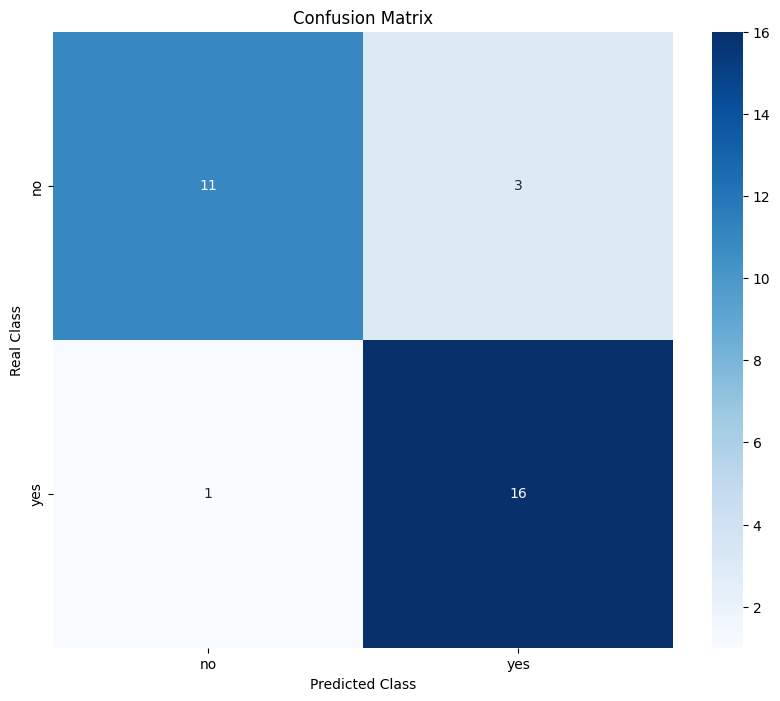

In [17]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Class")
plt.ylabel("Real Class")
plt.title("Confusion Matrix")
plt.show()

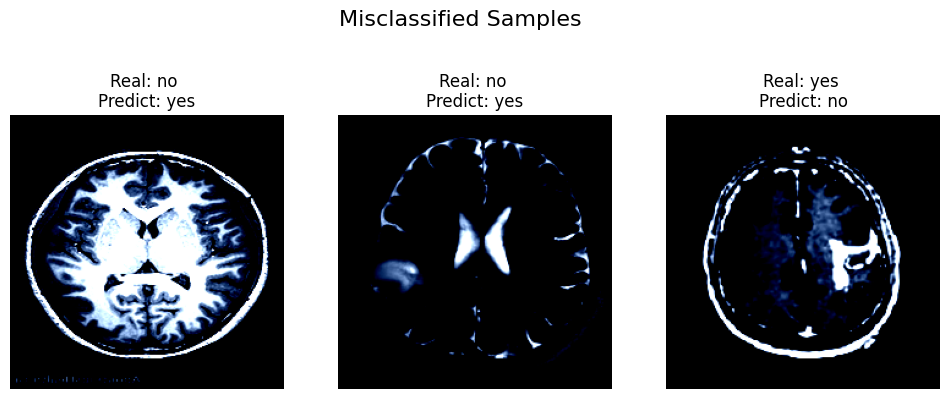

In [18]:
# Visualization of Misclassifications:
# Visualization of Misclassifications:
def plot_misclassified(model, test_loader, class_names):
    model.eval()
    misclassified = []
    
    with torch.no_grad():
        for batch_inputs, batch_labels in test_loader:
            batch_inputs, batch_labels = batch_inputs.to(device), batch_labels.to(device)
            outputs = model(batch_inputs)
            _, predicted = torch.max(outputs, 1)
            
            # Catch of wrong classifications
            for i in range(len(predicted)):
                if predicted[i] != batch_labels[i]:
                    misclassified.append((batch_inputs[i].cpu(), predicted[i].cpu(), batch_labels[i].cpu()))
    
    fig = plt.figure(figsize=(12, 5))
    rows, cols = 1, 3  # Number of images to display in the grid
    num_images = min(len(misclassified), rows * cols)  # Limit to the available misclassified samples
    
    for i in range(1, num_images + 1):
        img, predicted, actual = misclassified[i - 1]
        fig.add_subplot(rows, cols, i)
        plt.imshow(img.permute(1, 2, 0))
        plt.title(f"Real: {class_names[actual]} \nPredict: {class_names[predicted]}")
        plt.axis(False)

    plt.suptitle("Misclassified Samples", fontsize=16)
    plt.show()

plot_misclassified(resnet152_model, test_loader, class_names)


***Prediction***

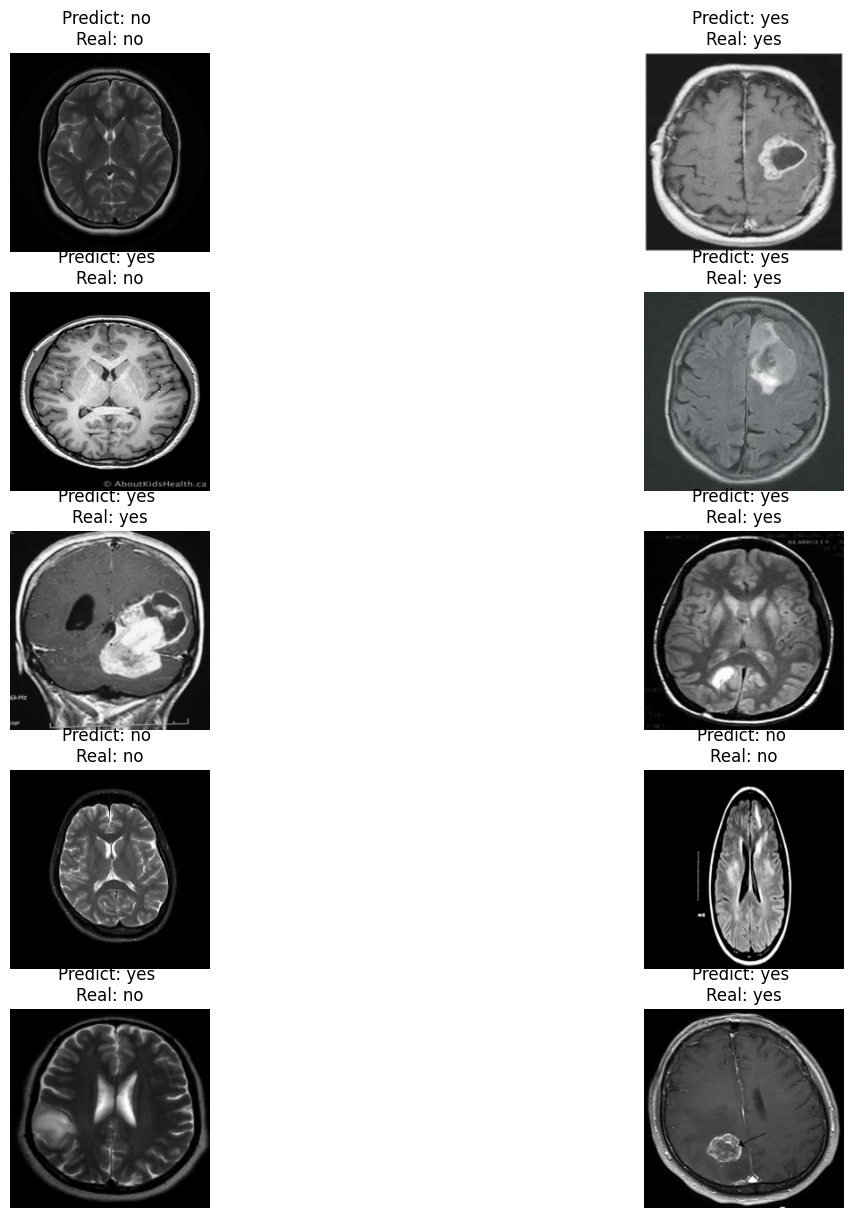

In [19]:
def predict_and_visualize_from_test(test_loader, model, class_names, num_images=5):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 15))

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Visualize images within each batch
            for i in range(inputs.size()[0]):
                if images_so_far == num_images:
                    return
                images_so_far += 1
                
                img = inputs[i].cpu().permute(1, 2, 0)  # Move image to CPU and edit channels
                img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])  # Reverse normalization
                
                fig.add_subplot(num_images // 2, 2, images_so_far)
                plt.imshow(img)
                plt.title(f"Predict: {class_names[preds[i]]} \nReal: {class_names[labels[i]]}")
                plt.axis('off')

    plt.show()

predict_and_visualize_from_test(test_loader, resnet152_model, class_names, num_images=10)

***Conclusion***

We have successfully built a brain tumor binary classification model using deep learning techniques. By applying transfer learning to the Resnet152 model and through appropriate model evaluation, we are able to detect whether a brain tumor is present, or not with the model we trained. We can use this model in different applications to detect brain tumors.